<a href="https://colab.research.google.com/github/jayeshranjan-ai/ajha5487/blob/main/DataCreationForFineTuningLlama.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pyarrow

In [2]:
# Install libraries
!pip install -q datasets transformers sentence_transformers faiss-gpu
#Faiss, a powerful library developed by Facebook, revolutionizes nearest-neighbor search implementations for large datasets.
#Faiss GPU utilization significantly enhances performance due to its optimization for memory-speed-accuracy tradeoffs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 75.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 16.1.0 which is 

In [4]:
# We will use Platypus Dataset
from google.colab import userdata
hf_token=userdata.get('huggingface')

In [5]:
from datasets import load_dataset
dataset = load_dataset("garage-bAInd/Open-Platypus")
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/24926 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction', 'data_source'],
        num_rows: 24926
    })
})

In [6]:
import pandas as pd

pd.DataFrame(dataset['train'])

,input,output,instruction,data_source
0,,To find the probability of the spinner landing...,A board game spinner is divided into three par...,MATH/PRM-800K
1,,"I need to choose 6 people out of 14, and the o...",My school's math club has 6 boys and 8 girls. ...,MATH/PRM-800K
2,,First we count the number of all 4-letter word...,How many 4-letter words with at least one cons...,MATH/PRM-800K
3,,She can do this if and only if at least one of...,Melinda will roll two standard six-sided dice ...,MATH/PRM-800K
4,,Think of the problem as a sequence of H's and ...,"Let $p$ be the probability that, in the proces...",MATH/PRM-800K
...,...,...,...,...
24921,,There are several formulas that generate all p...,Can we find a formula to generate all prime nu...,guanaco
24922,,"Sure, here are some of the best universities:\...",What are some of the best university's for stu...,guanaco
24923,,[Enter stage left]\n\nFirst Citizen: Good morr...,Write me a SPL (Shakespeare Programming Langua...,guanaco
24924,,That's a very thoughtful idea! Here are some s...,Hi. I want to make an embossed picture for my ...,guanaco


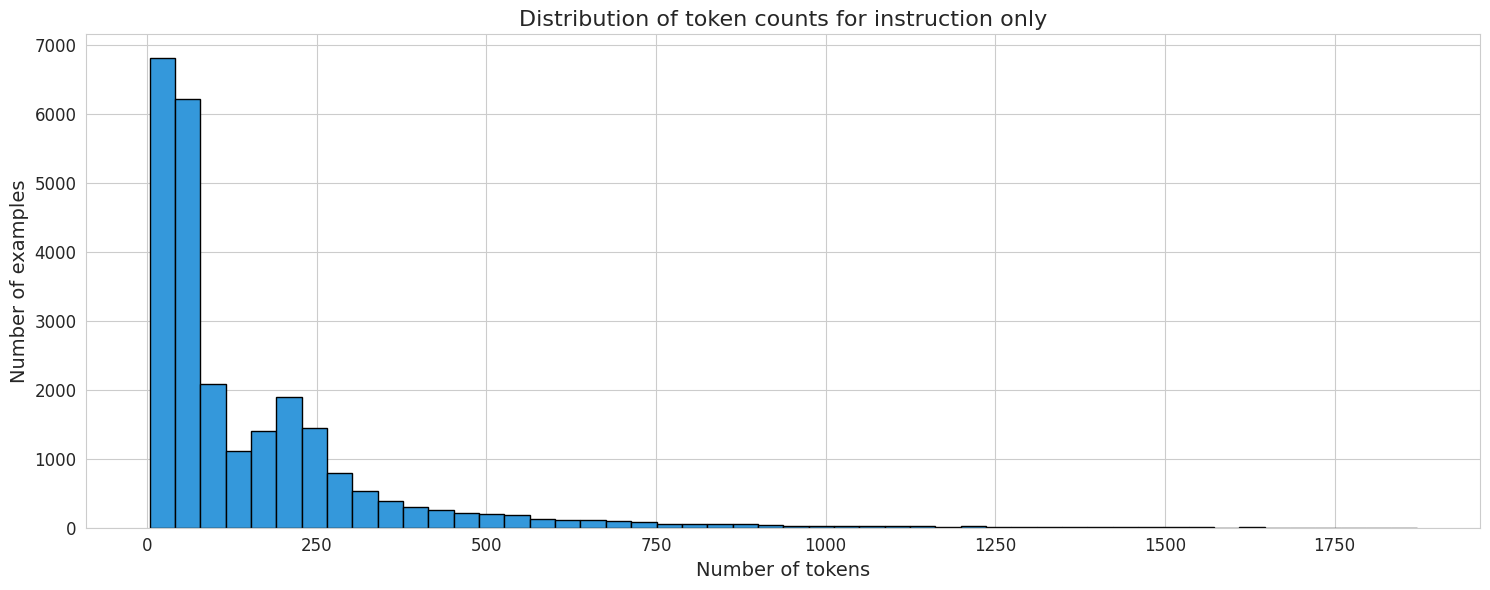

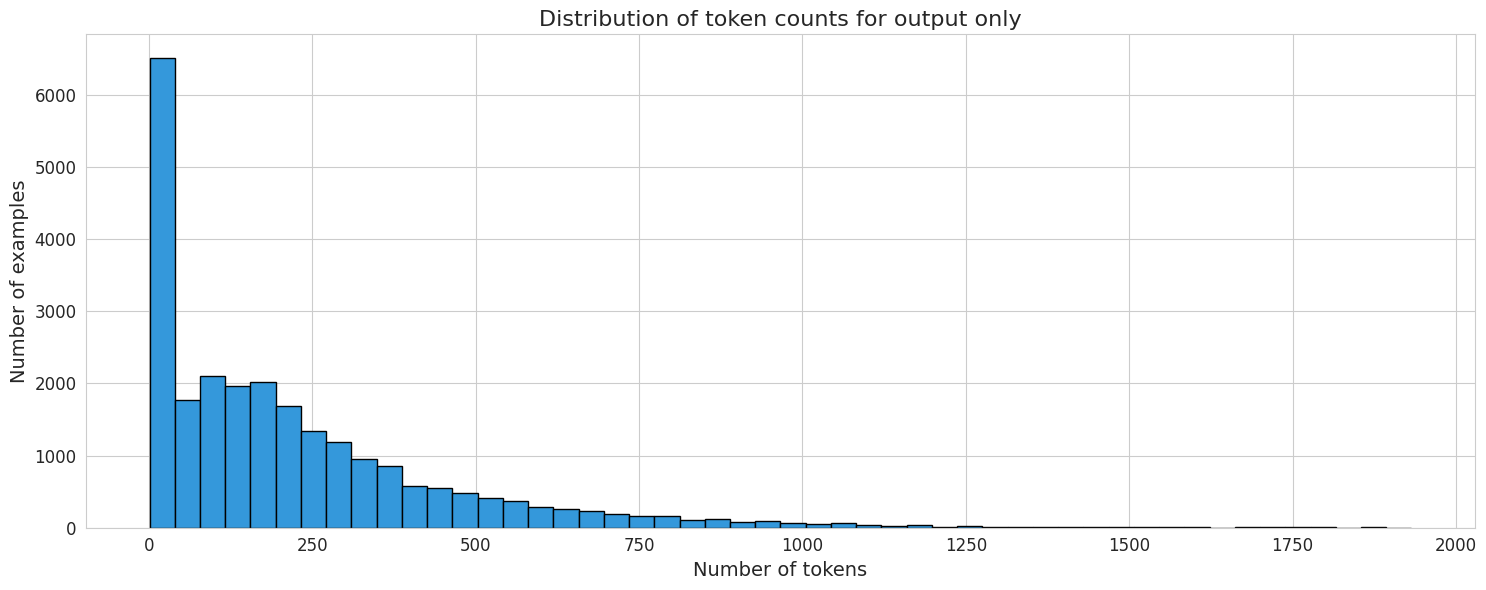

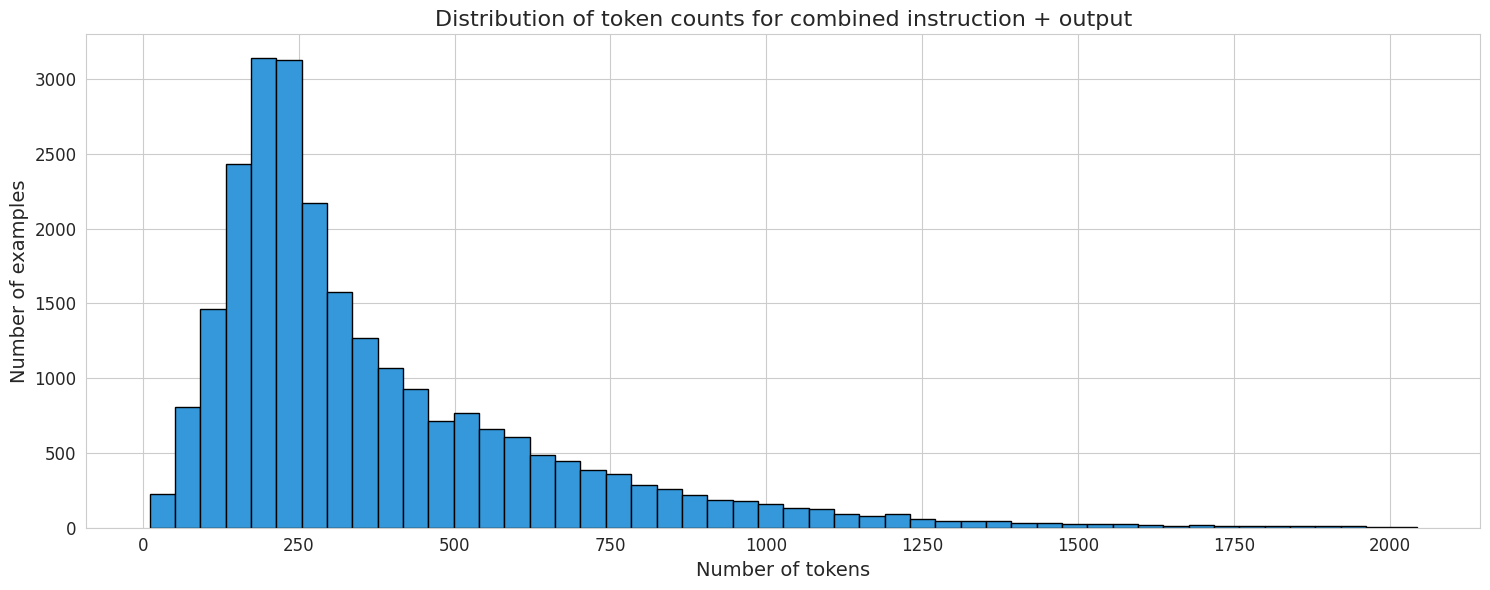

Number of valid rows: 24895
Removing 0 rows...


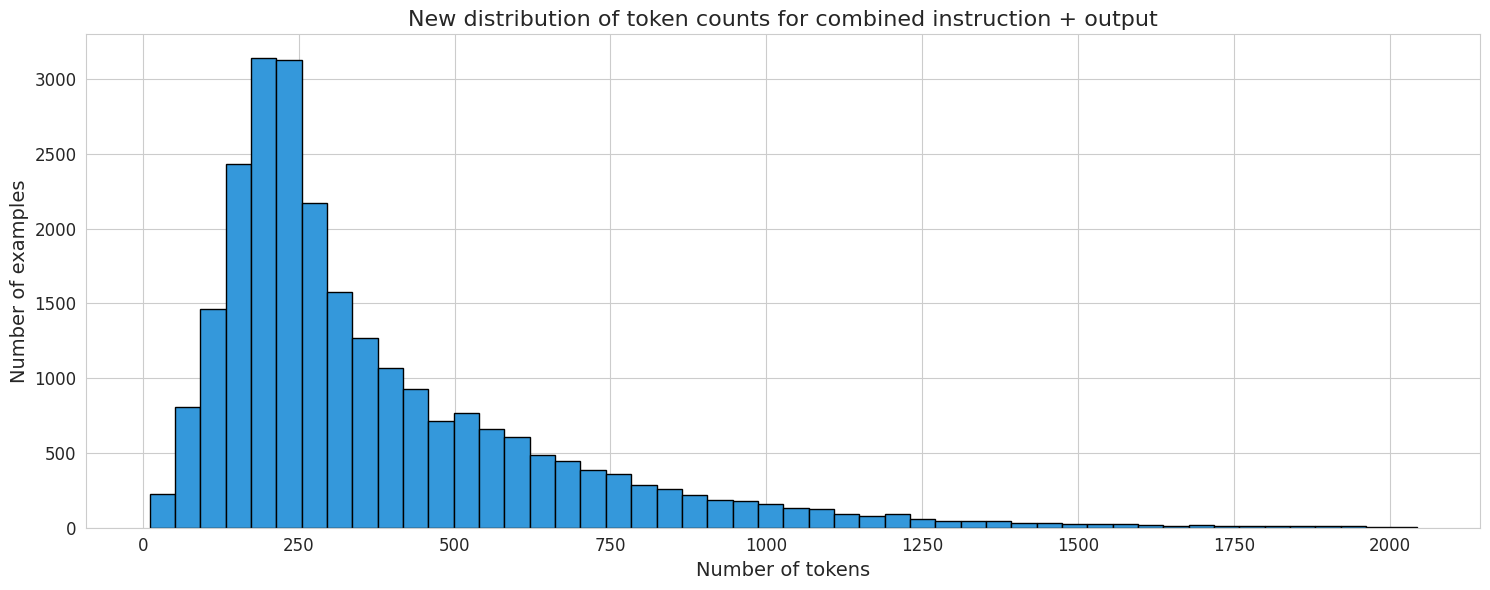

In [13]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("NousResearch/Llama-2-7b-chat-hf")

# Tokenize each row and count the number of tokens
instruction_token_counts = [len(tokenizer.tokenize(example["instruction"])) for example in dataset['train']]
output_token_counts = [len(tokenizer.tokenize(example["output"])) for example in dataset['train']]
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]

# Helper function to plot the distributions
def plot_distribution(token_counts, title):
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 6))
    plt.hist(token_counts, bins=50, color='#3498db', edgecolor='black')
    plt.title(title, fontsize=16)
    plt.xlabel("Number of tokens", fontsize=14)
    plt.ylabel("Number of examples", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

# Plot the distribution of token counts
plot_distribution(instruction_token_counts, "Distribution of token counts for instruction only")
plot_distribution(output_token_counts, "Distribution of token counts for output only")
plot_distribution(combined_token_counts, "Distribution of token counts for combined instruction + output")

# Filter out rows with more than 2048 tokens
valid_indices = [i for i, count in enumerate(combined_token_counts) if count <= 2048]
print(f"Number of valid rows: {len(valid_indices)}")
print(f"Removing {len(dataset['train']) - len(valid_indices)} rows...")

# Extract valid rows based on indices
dataset['train'] = dataset['train'].select(valid_indices)

# Get token counts for valid rows
token_counts = [combined_token_counts[i] for i in valid_indices]

# Plot the new distribution of token counts
plot_distribution(token_counts, "New distribution of token counts for combined instruction + output")


Number of valid rows: 24895
Removing 0 rows...


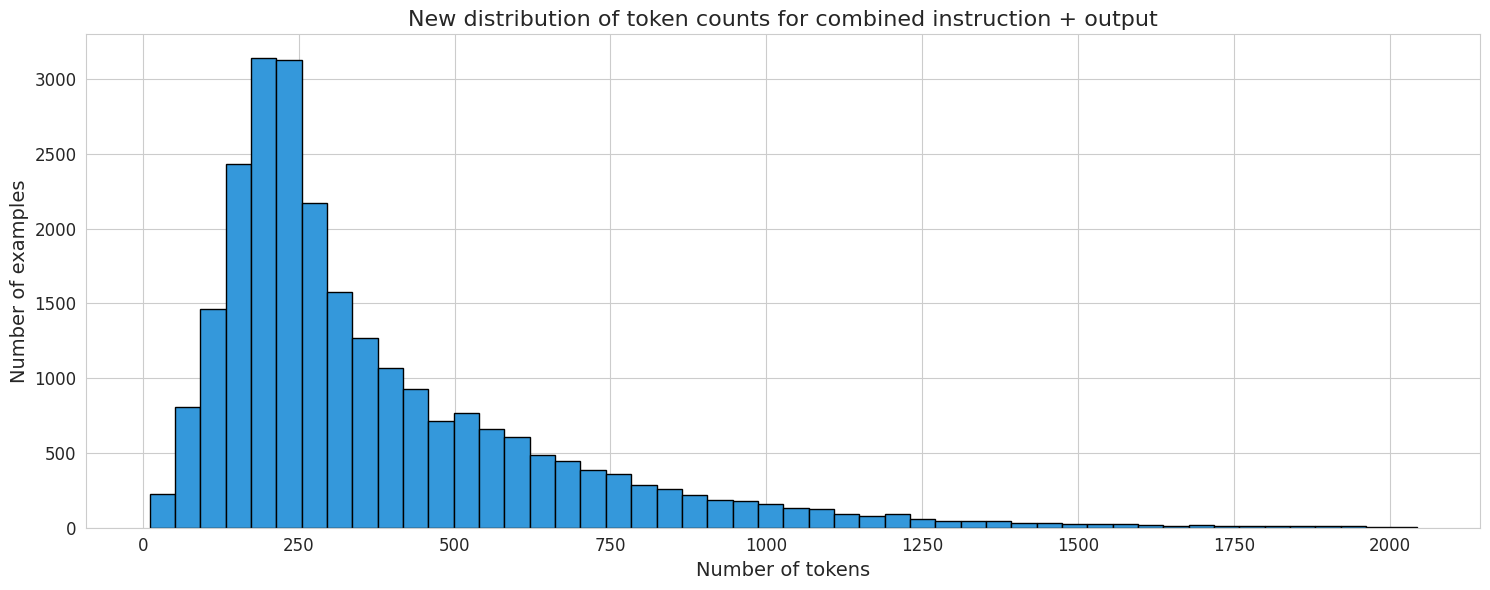

In [14]:
# Filter out rows with more than 2048 tokens
valid_indices = [i for i, count in enumerate(combined_token_counts) if count <= 2048]
print(f"Number of valid rows: {len(valid_indices)}")
print(f"Removing {len(dataset['train']) - len(valid_indices)} rows...")

# Extract valid rows based on indices
dataset['train'] = dataset['train'].select(valid_indices)

# Get token counts for valid rows
token_counts = [combined_token_counts[i] for i in valid_indices]

# Plot the new distribution of token counts
plot_distribution(token_counts, "New distribution of token counts for combined instruction + output")

In [ ]:
from sentence_transformers import SentenceTransformer
import faiss
from datasets import Dataset, DatasetDict
from tqdm.autonotebook import tqdm
import numpy as np

def deduplicate_dataset(dataset: Dataset, model: str, threshold: float):
    sentence_model = SentenceTransformer(model)
    outputs = [example["output"] for example in dataset['train']]

    print("Converting text to embeddings...")
    embeddings = sentence_model.encode(outputs, show_progress_bar=True)
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatIP(dimension)
    normalized_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    index.add(normalized_embeddings)

    print("Filtering out near-duplicates...")
    D, I = index.search(normalized_embeddings, k=2)
    to_keep = []

    for i in tqdm(range(len(embeddings)), desc="Filtering"):
        # If the second closest vector (D[i, 1]) has cosine similarity above the threshold
        if D[i, 1] >= threshold:
            # Check if either the current item or its nearest neighbor is already in the to_keep list
            nearest_neighbor = I[i, 1]
            if i not in to_keep and nearest_neighbor not in to_keep:
                # If not, add the current item to the list
                to_keep.append(i)
        else:
            # If the similarity is below the threshold, always keep the current item
            to_keep.append(i)

    dataset = dataset['train'].select(to_keep)
    return DatasetDict({"train": dataset})

deduped_dataset = deduplicate_dataset(dataset, "thenlper/gte-large", 0.95)

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.9k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Converting text to embeddings...


Batches:   0%|          | 0/778 [00:00<?, ?it/s]

In [ ]:
print(f"Number of samples in the original dataset: {len(dataset['train'])}")
print(f"Number of samples in the deduped dataset: {len(deduped_dataset['train'])}")
print(f"Number of samples that were removed: {len(dataset['train']) - len(deduped_dataset['train'])}")

In [ ]:
# Get the top k rows with the most tokens
def get_top_k_rows(dataset, token_counts, k):
    # Sort by descending token count and get top k indices
    sorted_indices = sorted(range(len(token_counts)), key=lambda i: token_counts[i], reverse=True)
    top_k_indices = sorted_indices[:k]

    # Extract top k rows
    top_k_data = {
        "instruction": [dataset['train'][i]["instruction"] for i in top_k_indices],
        "output": [dataset['train'][i]["output"] for i in top_k_indices]
    }

    return Dataset.from_dict(top_k_data)

# Get token counts
instruction_token_counts = [len(tokenizer.tokenize(example["instruction"])) for example in deduped_dataset['train']]
output_token_counts = [len(tokenizer.tokenize(example["output"])) for example in deduped_dataset['train']]
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]

k = 1000  # You can adjust this value as needed
top_k_dataset = get_top_k_rows(deduped_dataset, combined_token_counts, k)

# Save these rows in a Dataset object with a 'train' split
dataset = DatasetDict({"train": top_k_dataset})

In [ ]:
instruction_token_counts = [len(tokenizer.tokenize(example["instruction"])) for example in dataset['train']]
output_token_counts = [len(tokenizer.tokenize(example["output"])) for example in dataset['train']]
combined_token_counts = [instruction + output for instruction, output in zip(instruction_token_counts, output_token_counts)]

# Plot the distribution of token counts
plot_distribution(instruction_token_counts, "Distribution of token counts for instruction only")
plot_distribution(output_token_counts, "Distribution of token counts for output only")
plot_distribution(combined_token_counts, "Distribution of token counts for combined instruction + output")

In [ ]:
# Read as pandas DataFrame
dataset['train'].to_pandas()

In [ ]:
[
    {"role": "user", "content": "Hi there!"},
    {"role": "assistant", "content": "Nice to meet you!"}
]

In [ ]:
User: Hey there!
Assistant: Nice to meet you!

In [ ]:
<s>[INST] <<SYS>>
System prompt
<</SYS>>

User prompt [/INST] Model answer </s>

In [ ]:
<|im_start|>user
Hey there!<|im_end|>
<|im_start|>assistant
Nice to meet you!<|im_end|>

In [ ]:
def chat_template(example):
    example["instruction"] = f"### Instruction:\n{example['instruction']}\n\n### Response:\n"
    return example

dataset = dataset.map(chat_template)

In [ ]:
dataset['train'].to_pandas()

In [ ]:
# Optional: push to Hugging Face Hub
dataset.push_to_hub("mini-platypus", token=hf_token)